In [1]:
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from glob import glob

from eofs.xarray import Eof

# import from parent dir
import sys 
sys.path.append('..')
from path_parameters import TRAIN_PATH, TEST_PATH, OUTPUT_PATH

In [2]:
data_path = TRAIN_PATH
output_path = OUTPUT_PATH + "outputs_ssp245_prediction_pattern.nc"

# path to testing data (ssp245)
pathssp245_Y = TEST_PATH + "outputs_ssp245.nc"
pathssp245_X = TEST_PATH + "inputs_ssp245.nc"


In [3]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

# data_path = "./"

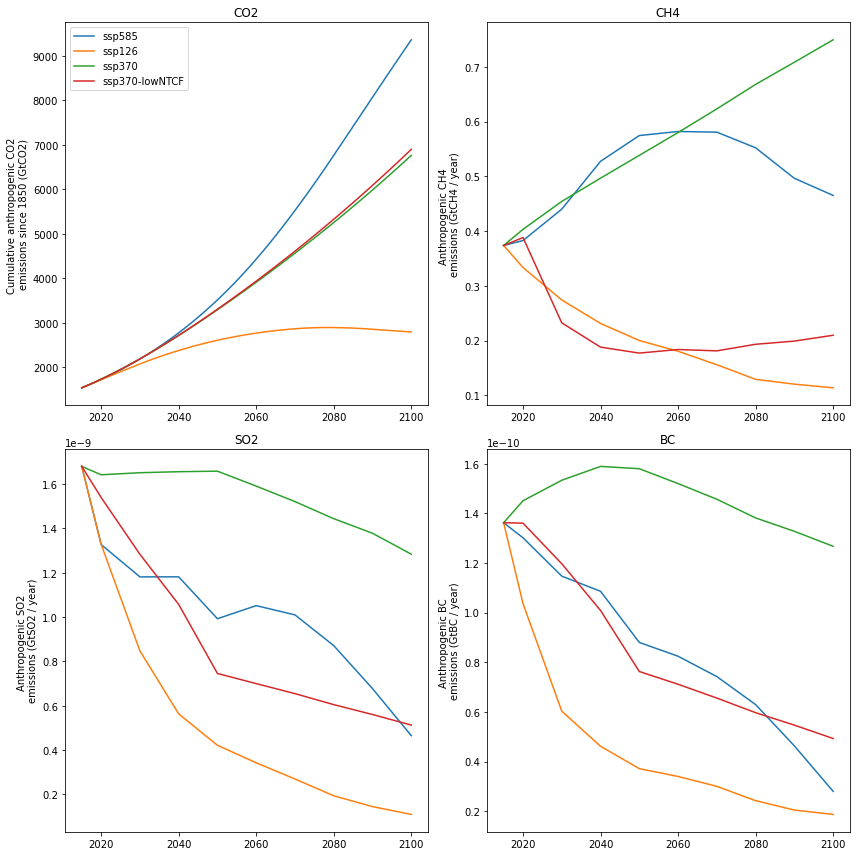

In [5]:
# TODO: why are these empty plots??
inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for i in inputs:
    
    label = i.split('/')[-1].split('_')[-1][:-3]
    X = xr.open_dataset(i)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

In [6]:
# Get one combined historical + ssp585 + ssp126 + ssp370 timeseries for now
X = xr.concat([xr.open_dataset(data_path + 'inputs_historical.nc'), xr.open_dataset(data_path + 'inputs_ssp585.nc'),xr.open_dataset(data_path+ 'inputs_ssp126.nc'),xr.open_dataset(data_path+ 'inputs_ssp370.nc')], dim='time').compute()

# Take the 2nd ensemble member for the historical (the first one has some missing DTR values for some reason...) and the 1st one for ssp585, ssp126, ssp370
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp126.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp370.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"]=np.arange(1,424) 
Y["time"]=np.arange(1,424)
        

In [7]:
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

In [8]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [9]:
y_inp_tas=Y["tas"].stack(dim=["lat", "lon"])
y_inp_pr=Y["pr"].stack(dim=["lat", "lon"])
y_inp_pr90=Y["pr90"].stack(dim=["lat", "lon"])
y_inp_dtr=Y["diurnal_temperature_range"].stack(dim=["lat", "lon"])

In [10]:
reg0 = LinearRegression()
reg1 = LinearRegression()
reg2 = LinearRegression()
reg3 = LinearRegression()

rf_tas = reg0.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_tas)
rf_pr = reg1.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_pr)
rf_pr90 = reg2.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_pr90)
rf_dtr = reg3.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_dtr)

In [11]:
## Test on SSP245

test_Y = xr.open_dataset(pathssp245_Y).compute()
test_X = xr.open_dataset(pathssp245_X).compute()

tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

test_inputs = test_Y['tas'].mean('member').weighted(weights).mean(['lat', 'lon']).to_pandas()

In [12]:
test_inputs

time
2015    0.713779
2016    0.763537
2017    0.781224
2018    0.893932
2019    0.976603
          ...   
2096    1.997864
2097    2.011481
2098    2.176375
2099    2.136417
2100    2.154701
Length: 86, dtype: float64

In [13]:
m_out_t = rf_tas.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p = rf_pr.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p90 = rf_pr90.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_d = rf_dtr.predict(test_inputs.to_numpy()[:, np.newaxis])

m_out_tas = m_out_t.reshape(86, 96, 144)
m_out_pr = m_out_p.reshape(86, 96, 144)
m_out_pr90 = m_out_p90.reshape(86, 96, 144)
m_out_dtr = m_out_d.reshape(86, 96, 144)

In [14]:
xr_output=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  m_out_dtr)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["pr90"]=(['time', 'lat', 'lon'],  m_out_pr90)
    
#save output to netcdf 
xr_output.to_netcdf(output_path,'w')

In [15]:
print(f"RMSE: {get_rmse(tas_truth[65:], m_out_tas[65:])}")
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:])}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[65:], m_out_dtr[65:])}")
print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:])}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[65:], m_out_pr[65:])}")
print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:])}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[65:], m_out_pr90[65:])}")
print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:])}")

RMSE: 0.3543582578019788
RMSE: 0.34399135258419206


RMSE: 0.1541410087417996
RMSE: 0.14718339141622516


RMSE: 0.5583826048843104
RMSE: 0.5228081989759267


RMSE: 1.6012070151865376
RMSE: 1.5195187998818873


In [16]:
m_out_tas[65:].shape

(21, 96, 144)

[Text(0.5, 1.0, 'Difference')]

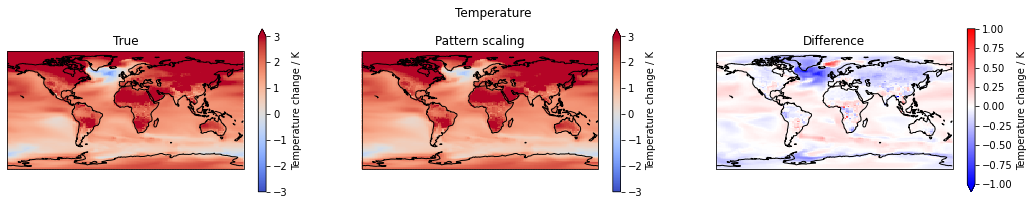

In [17]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["tas"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = tas_truth - xr_output["tas"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=1,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

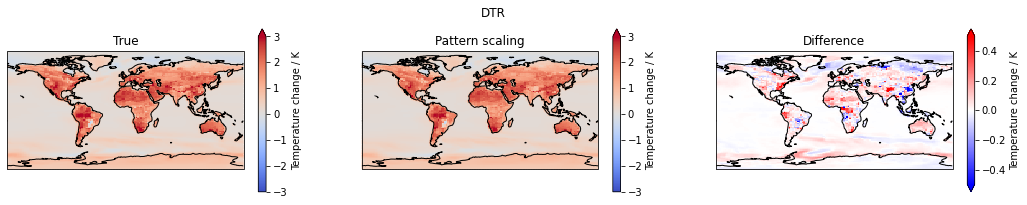

In [18]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["diurnal_temperature_range"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = dtr_truth - xr_output["diurnal_temperature_range"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=0.5,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

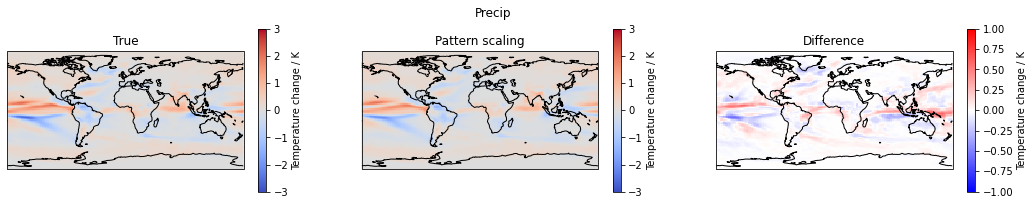

In [19]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precip')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["pr"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = pr_truth - xr_output["pr"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=1,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

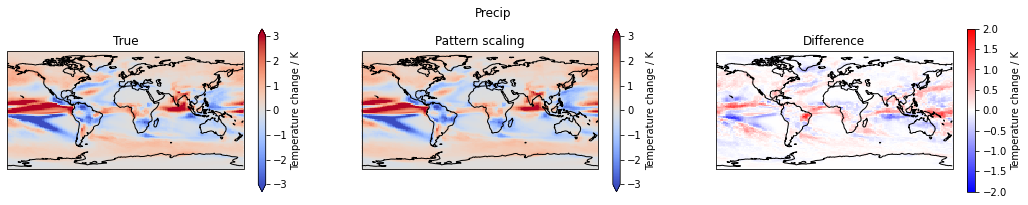

In [20]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precip')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["pr90"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = pr90_truth - xr_output["pr90"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=2,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')